# Capstone Project: Classifying clinically actionable genetic mutations

***

## Notebook 4: Alternative Model

This notebook contains code to find a suitable alternative model to address the classification problem, by exploring static word embeddings.

### Contents

- [Importing of Libraries](#Importing-of-Libraries)
- [Data Import](#Data-Import)
- [Preparation for Modelling](#Preparation-for-Modelling)
- [Exploring static word embeddings](#Exploring-static-word-embeddings)
    - [Loading of pre-trained word embeddings based on GloVe](#Loading-of-pre-trained-word-embeddings-based-on-GloVe)
    - [Creation of Word2Vec word embeddings based on training dataset vocabulary](#Creation-of-Word2Vec-word-embeddings-based-on-training-dataset-vocabulary)
    - [Finding the best combination of word embeddings and vectorizer](#Finding-the-best-combination-of-word-embeddings-and-vectorizer)
- [Creation of (Inner) Training and Validation Datasets](#Creation-of-(Inner)-Training-and-Validation-Datasets)
- [Combining word embeddings with dummy columns](#Combining-word-embeddings-with-dummy-columns)
- [Handling of imbalanced classes](#Handling-of-imbalanced-classes)
- [Scaling the data for PCA](#Scaling-the-data-for-PCA)
- [Dimensionality reduction using PCA](#Dimensionality-reduction-using-PCA)
- [Randomised search for optimal classifier parameters](#Randomised-search-for-optimal-classifier-parameters)
- [Selection of Alternative Model](#Selection-of-Alternative-Model)
- [Further Exploration of Alternative Model](#Further-Exploration-of-Alternative-Model)
    - [Logistic Regression Coefficients](#Logistic-Regression-Coefficients)
    - [ROC curves and metrics for Validation Dataset](#ROC-curves-and-metrics-for-Validation-Dataset)
    - [Confusion Matrix](#Confusion-Matrix)
    - [Comparison of Frequency Distributions](#Comparison-of-Frequency-Distributions)
- [Selection of Final Model](#Selection-of-Final-Model)
- [Data Export (for Kaggle Submission)](#Data-Export-(for-Kaggle-Submission))

## Importing of Libraries

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from itertools import cycle
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Additional general purpose libraries
import time
import datetime
import pickle
from tabulate import tabulate
from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict

# Used for GloVe word embeddings
import struct
GLOVE_6B_50D_PATH = "../assets/glove.6B.50d.txt"
GLOVE_6B_300D_PATH = "../assets/glove.6B.300d.txt"
encoding="utf-8"

# scikit-learn machine learning libraries
from sklearn import linear_model, metrics, svm
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.metrics import roc_curve, auc, f1_score, balanced_accuracy_score,\
    plot_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

# Used for visualising specific trees
from sklearn.tree import export_graphviz
from subprocess import call 
from IPython.display import Image

# Used for oversampling
from imblearn.over_sampling import ADASYN

# Used for forward neural network classifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers

# Initialise random seeed for more consistent results
from numpy.random import seed
seed(42)

Using TensorFlow backend.


## Data Import

In [2]:
# Import 'train_prep' and 'test_prep' datasets
# We use the 'keep_default_na' option to False to ensure that pandas does not re-introduce missing values
train = pd.read_csv("../assets/train_prep.csv", keep_default_na=False)
test = pd.read_csv("../assets/test_prep.csv", keep_default_na=False)

In [3]:
train.shape, test.shape

((3321, 4325), (986, 4324))

In [4]:
train.head(2)

,id,class,text,gene_ABCB11,gene_ABCC6,gene_ABL1,gene_ACVR1,gene_ADAMTS13,gene_ADGRG1,gene_AGO2,...,variation_YAP1-TFE3 Fusion,variation_YWHAE-ROS1 Fusion,variation_ZC3H7B-BCOR Fusion,variation_ZNF198-FGFR1 Fusion,variation_null1313Y,variation_null189Y,variation_null262Q,variation_null267R,variation_null399R,variation_p61BRAF
0,0,1,cyclin dependent kinase cdks regulate variety ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,abstract background non small lung nsclc heter...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test.head(2)

,id,text,gene_ABCB11,gene_ABCC6,gene_ABL1,gene_ACVR1,gene_ADAMTS13,gene_ADGRG1,gene_AGO2,gene_AGXT,...,variation_YAP1-TFE3 Fusion,variation_YWHAE-ROS1 Fusion,variation_ZC3H7B-BCOR Fusion,variation_ZNF198-FGFR1 Fusion,variation_null1313Y,variation_null189Y,variation_null262Q,variation_null267R,variation_null399R,variation_p61BRAF
0,1,incidence breast increase china recent decade ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,unselected series colorectal carcinoma stratif...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Preparation for Modelling

In [6]:
# Splitting of data into Predictor (X) and Target (y) Dataframes
X = train[[i for i in train.columns if i not in ['id', 'class']]]
y = train['class']

In [7]:
X.shape, y.shape

((3321, 4323), (3321,))

In [8]:
# Save copies of the original X and y dataframes so that we can try different word embeddings as needed
X_original = X.copy()
y_original = y.copy()

In [9]:
X_test = test.drop(['id'], axis=1)

In [10]:
X_test.shape

(986, 4323)

In [11]:
%%time
# For convenience, we create an array called 'X_all_text that contains
# all the text from our training set, across all samples
X_all_text = []
for text in X['text']:
    X_all_text.append(text.split())
X_all_text = np.array(X_all_text)

Wall time: 2.21 s


In [12]:
X_all_text.shape

(3321,)

In [13]:
# Create a set of all the unique words from our taining set, across all samples
X_unique_words = set()
for row in range(len(X_all_text)):
    X_unique_words.update(X_all_text[row])

In [14]:
len(X_unique_words)

81312

In [15]:
max_phrase_len = 0
for row in range(len(X_all_text)):
    if len(X_all_text[row]) > max_phrase_len:
        max_phrase_len = len(X_all_text[row])

In [16]:
max_phrase_len

44019

## Exploring static word embeddings

In this notebook, we evaluate two static word embeddings as an alternative representation of the words in the clinical text, instead of the weighted word counts created using TfidfVectorizer in the baseline model.

As explained by Jason Brownless at https://machinelearningmastery.com/develop-word-embeddings-python-gensim/:

A word embedding is a dense vector representation of words that capture their meaning in some way. Word embeddings are an improvement over simpler word encoding schemes (like TfidfVectorizer) that result in large and sparse vectors that describe documents but not the meaning of the words. Word embeddings work by using an algorithm to train a set of fixed-length dense and continuous-valued vectors based on a large corpus of text. Each word is represented by a point in the embedding space and these points are learned and moved around based on the words that surround the target word.

It is defining a word by the company that it keeps that allows the word embedding to learn something about the meaning of words. The vector space representation of the words provides a projection where words with similar meanings are locally clustered within the space.

The use of word embeddings over other text representations is one of the key methods that has led to breakthrough performance with deep neural networks on problems like machine translation.

We explore three static word embeddings to see if we can get better classification results:
1. A smaller set of GloVe embeddings (which we call **'glove_small'**) that are based on based on Wikipedia 2015 and Gigaword 5th Edition (https://catalog.ldc.upenn.edu/LDC2011T07). Global Vectors for Word Representation (GloVe) are pre-trained word embeddings created by the [Stanford Natural Language Processing Group](https://nlp.stanford.edu/) and available at https://nlp.stanford.edu/projects/glove/.
2. A larger set of GloVe embeddings (which we call **'glove_big'**) that are based on Common Crawl (https://commoncrawl.org/)
3. Our own word embeddings created by training Word2Vec (from nltk) on all the given text in the training dataset, which we call **'w2v'**.

The embeddings are 'static' in the sense that they do not take the context of the whole document that each word is found in, i.e. the other words in the same document.

### Loading of pre-trained word embeddings based on GloVe

We now load the two pre-trained word embeddings (based on GloVe) and store them as dictionary objects 'glove_small' and 'glove_big'.

In [17]:
%%time

# glove_small keys are bounded by what is common to both the X_all_text and the glove file
glove_small = {}
all_words = set(w for words in X_all_text for w in words)
with open(GLOVE_6B_50D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums

# glove_big keys are bounded by what is common to both the X_all_text and the glove file
glove_big = {}
with open(GLOVE_6B_300D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if word in all_words:
            nums=np.array(parts[1:], dtype=np.float32)
            glove_big[word] = nums

Wall time: 10.4 s


### Creation of Word2Vec word embeddings based on training dataset vocabulary

We now create our own word embeddings using Word2Vec from nltk, trained using all the text in the training dataset.

In [18]:
%%time
model = Word2Vec(X_all_text, size=100, window=5, min_count=5, workers=8)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

Wall time: 58.5 s


C:\Users\yuchy\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


### Defining new Vectorizers

We define two word embedding vectorizers:
- **MeanEmbeddingVectorizer**: takes the mean of all the 'glove_small' vectors corresponding to individual words
- **TfidfEmbeddingVectorizer** takes the mean of all the 'glove_small' vectors corresponding to individual words **weighted** based on each word's inverse document frequency. 

In [19]:
class MeanEmbeddingVectorizer(object):
    
    # Creating a new MeanEmbeddingVectorizer object with input parameter of 'word2vec'
    # will create a new array of size equal to the number of words contained in word2vec
    # that are also present in the glove_small dictionary
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
            
    # The 'fit' method simply returns the input parameter 'word2vec' itself
    def fit(self, X, y):
        return self 

    # The 'transform' method returns an array consisting of the mean of all
    # 'glove_small" vectors that correspond to individual words in the input parameter 'X'
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

# TfidfVectorizer is a variation of the Term Frequency - Inverse Document Frequency (Tfidf) Vectorizer
class TfidfEmbeddingVectorizer(object):
    
    # Creating a new TfidfEmbeddingVectorizer object with input parameter of 'word2vec'
    # will create an array of size equal to the number of words contained in word2vec
    # that are also present in the glove_small dictionary
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
        
    # The 'fit' method updates the word weights attribute based on the
    # output of the standard TfidfVectorizer
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    # The 'transform' method returns an array consisting of the mean of all 'glove_small'
    # vectors (adjusted by the Tfidf weights) that correspond to individual words
    # in the input parameter 'X'
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

### Finding the best combination of word embeddings and vectorizer

To identify the best combination of the alternative word embeddings above and the vectorizers defined above, we calculate cross-validated accuracy scores for different pipelines (i.e. combinations) of the word embeddings and vectorizers, coupled with the Extra Trees classifier. The Extra Trees Classifier is chosen based on its generally good performance; it produces less variance but may cause an increase in bias, compared to a Random Forest classifier.

Our goal is to pin down our chosen word embeddings and vectorizer for subsequent training of the classifier.

The different pipelines are as follows:
- mev_w2v: MeanEmbeddingVectorizer based on our own 'w2v' word vectors created using Word2Vec on the words in the training dataset
- tev_w2v: TfidfEmbeddingVectorizer based on our own 'w2v word vectors
- mev_glove_small: MeanEmbeddingVectorizer based on the 'glove_small' word vectors
- tev_glove_small: TfidfEmbeddingVectorizer based on the 'glove_small' word vectors
- mev_glove_big: MeanEmbeddingVectorizer based on the 'glove_big' word vectors
- tev_glove_big: TfidfEmbeddingVectorizer based on the 'glove_big' word vectors

In [20]:
# Create the various pipelines for evaluation
mev_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
tev_w2v = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
mev_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
tev_glove_small = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
mev_glove_big = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
tev_glove_big = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])

We now obtain the 3-fold cross-validation accuracy scores for each pipeline based on the labels 'y' (i.e. variation classes), and sort them in descending order of cross-validation accuracy score.

In [21]:
%%time
all_models = [
    ("mev_w2v", mev_w2v),
    ("tev_w2v", tev_w2v),
    ("mev_glove_small", mev_glove_small),
    ("tev_glove_small", tev_glove_small),
    ("mev_glove_big", mev_glove_big),
    ("tev_glove_big", tev_glove_big)
]

unsorted_scores = [(name, cross_val_score(model, X_all_text, y, cv=3, verbose=1, n_jobs=4).mean())
                   for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])
print (tabulate(scores, floatfmt=".4f", headers=("Model", 'Cross-Validation Accuracy Score')))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   49.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   42.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  2.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Model              Cross-Validation Accuracy Score
---------------  ---------------------------------
mev_w2v                                     0.4312
tev_w2v                                     0.4140
mev_glove_small                             0.3957
mev_glove_big                               0.3773
tev_glove_small                             0.3433
tev_glove_big                               0.3327
Wall time: 9min 28s


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  2.5min finished


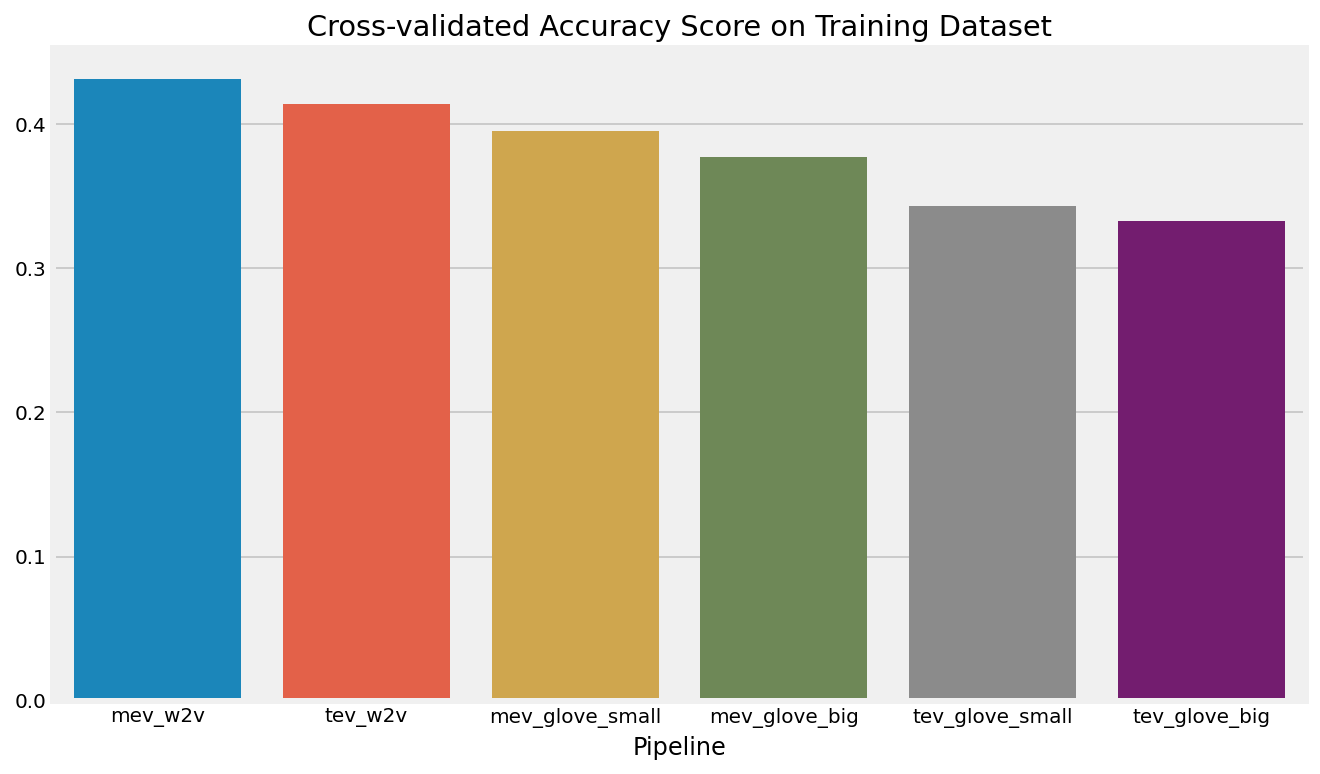

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores]);
plt.title("Cross-validated Accuracy Score on Training Dataset")
plt.xlabel("Pipeline");

<div class="alert alert-block alert-info">
As shown above, the <b>Mean Embedding Vectorizer</b> (mev) performs best together with the <b>Word2Vec</b> (w2v) word embedding based on the training dataset vocabulary, as it scores the highest in terms of the cross-validated accuracy score.<br>

We now evaluate two options for identifying the right classifier - a Forward Neural Network (FNN) and an Extra Trees Classifier.
</div>

## Creation of (Inner) Training and Validation Datasets

From our single training data set (X and y) we will create two separate datasets:
- (Inner) Training Dataset: this will be used to train our models (this will take 75% of the original training dataset)
- Validation Dataset: this will be used to validate our trained models (e.g. check for overfitting) (this will take 25% of our total 'posts' dataset

To create our datasets, we use train_test_split with the stratify option to ensure a consistent mix of values for the target feature within the created datasets.

In [23]:
# Restore the original predictor and target dataframes
X = X_original.copy()
y = y_original.copy()

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

In [25]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2490, 4323), (2490,), (831, 4323), (831,))

In [26]:
# Reset the indices to prevent spurious rows from appearing later during merging
X_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)

## Generation of word embeddings

We now generate word embeddings for our text using the set of best performing word embeddings identified earlier, i.e. the Word2Vec word embeddings we created using the MeanEmbeddingVectorizer.

In [27]:
# Instantiate a Mean Embedding Vectorizer object using the Word2Vec word embeddings
mev = MeanEmbeddingVectorizer(w2v)

In [28]:
%%time
X_train_mev = mev.fit(X_train['text'], y_train)
X_train_mev = mev.transform(X_train['text'])
X_val_mev = mev.transform(X_val['text'])
X_test_mev = mev.transform(X_test['text'])

Wall time: 59.3 s


In [29]:
X_train_mev.shape, X_val_mev.shape, X_test_mev.shape

((2490, 100), (831, 100), (986, 100))

In [30]:
X_train_mev_df = pd.DataFrame(X_train_mev)
X_val_mev_df = pd.DataFrame(X_val_mev)
X_test_mev_df = pd.DataFrame(X_test_mev)

In [31]:
X_train_mev_df.shape, X_val_mev_df.shape, X_test_mev_df.shape

((2490, 100), (831, 100), (986, 100))

In [32]:
X_train_mev_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2.187547,-0.728763,0.237446,2.545099,-2.767796,-0.846157,-0.345383,2.083947,1.585878,-0.379076,...,-3.949122,-2.271590,0.737321,-1.025528,1.481053,1.293013,1.724087,2.708411,1.768898,-0.981080
1,2.271715,-0.732242,0.111455,2.523629,-2.862206,-0.869411,-0.431319,2.108749,1.678582,-0.353904,...,-4.010534,-2.242504,0.706177,-1.009549,1.479006,1.268857,1.780314,2.556909,1.776606,-1.093082
2,2.255527,-0.698574,0.264950,2.507111,-2.793411,-0.890244,-0.373044,2.081129,1.743507,-0.466863,...,-3.978585,-2.264089,0.770119,-1.030855,1.445574,1.294258,1.799755,2.655034,1.812378,-1.035900
3,2.255885,-0.705506,0.163638,2.509258,-2.786111,-0.841308,-0.384654,2.009213,1.628515,-0.370519,...,-3.939109,-2.286459,0.729493,-1.035778,1.486097,1.205084,1.677031,2.598013,1.781994,-1.022240
4,2.216316,-0.724495,0.176719,2.558857,-2.782972,-0.857720,-0.343737,2.067373,1.645102,-0.369530,...,-4.002358,-2.279040,0.730253,-0.975340,1.476457,1.275820,1.722572,2.636914,1.778762,-1.005931


## Combining word embeddings with dummy columns

In [33]:
# Concatenate the components parts of the dataframe
X_train = pd.concat([X_train, X_train_mev_df], axis=1)
X_val = pd.concat([X_val, X_val_mev_df], axis=1)
X_test = pd.concat([X_test, X_test_mev_df], axis=1)

In [34]:
X_train.drop(columns=['text'], inplace=True)
X_val.drop(columns=['text'], inplace=True)
X_test.drop(columns=['text'], inplace=True)

In [35]:
X_train.shape, X_val.shape, X_test.shape

((2490, 4422), (831, 4422), (986, 4422))

In [36]:
X_train.head()

,gene_ABCB11,gene_ABCC6,gene_ABL1,gene_ACVR1,gene_ADAMTS13,gene_ADGRG1,gene_AGO2,gene_AGXT,gene_AKAP9,gene_AKT1,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,-3.949122,-2.271590,0.737321,-1.025528,1.481053,1.293013,1.724087,2.708411,1.768898,-0.981080
1,0,0,0,0,0,0,0,0,0,0,...,-4.010534,-2.242504,0.706177,-1.009549,1.479006,1.268857,1.780314,2.556909,1.776606,-1.093082
2,0,0,0,0,0,0,0,0,0,0,...,-3.978585,-2.264089,0.770119,-1.030855,1.445574,1.294258,1.799755,2.655034,1.812378,-1.035900
3,0,0,0,0,0,0,0,0,0,0,...,-3.939109,-2.286459,0.729493,-1.035778,1.486097,1.205084,1.677031,2.598013,1.781994,-1.022240
4,0,0,0,0,0,0,0,0,0,0,...,-4.002358,-2.279040,0.730253,-0.975340,1.476457,1.275820,1.722572,2.636914,1.778762,-1.005931


In [37]:
# Save the column names for subsequent visualisation
X_train_cols = X_train.columns

## Handling of imbalanced classes

In [38]:
y_train.value_counts(normalize=True)

7    0.287149
4    0.206426
1    0.171084
2    0.136145
6    0.082731
5    0.072691
3    0.026908
9    0.011245
8    0.005622
Name: class, dtype: float64

In [39]:
y_train.value_counts()

7    715
4    514
1    426
2    339
6    206
5    181
3     67
9     28
8     14
Name: class, dtype: int64

We follow the same oversampling strategy as per the baseline model -- i.e. we use ADASYN to oversample the 3 most infrequent classes to be approx. 100 samples each.

In [40]:
# Instantiate an ADASYN object to oversample minority classes
adasyn = ADASYN(random_state=42, sampling_strategy={3:100, 9:100, 8:100}, n_jobs=4)

In [41]:
%%time
X_train, y_train = adasyn.fit_sample(X_train, y_train)

Wall time: 9.06 s


In [42]:
X_train.shape, y_train.shape

((2675, 4422), (2675,))

In [43]:
# Verify that we now have 181 samples for classes '5', '3' and '8'.
y_train.value_counts()

7    715
4    514
1    426
2    339
6    206
5    181
8    100
3     99
9     95
Name: class, dtype: int64

## Scaling the data for PCA

In [44]:
ss = StandardScaler()

In [45]:
ss.fit(pd.concat([X_train, X_val])) # we fit the StandardScaler based on all our training and validation data
X_train = ss.transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

## Dimensionality reduction using PCA

We use principle component analysis (PCA) to try and reduce the dimensions (i.e. number of features) for our various datasets, to transform the original features into new "high-performing" features, reduce the dimensionality of data, and reduce/eliminate multicollinearity. We accept that while this technique may yield better metrics for our models, it makes it difficult to interpret the final set of components (i.e. features) in the model.

In [46]:
# Initialise a PCA object
# We use the default n_components value ('None') which will take the value min(n_samples, n_features) - 1
pca = PCA(random_state=42, n_components=None)

In [47]:
%%time
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

Wall time: 10.2 s


In [48]:
X_train_pca.shape, X_val_pca.shape, X_test_pca.shape

((2675, 2675), (831, 2675), (986, 2675))

We observe above that the number of features have been significantly reduced to the number samples (approx. 39% reduction).

In [49]:
features_pca = ['PC'+str(i+1) for i in range(pca.n_components_)]
X_train_pca = pd.DataFrame(X_train_pca, columns=features_pca)
X_val_pca = pd.DataFrame(X_val_pca, columns=features_pca)
X_test_pca = pd.DataFrame(X_test_pca, columns=features_pca)

In [50]:
X_train_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC2666,PC2667,PC2668,PC2669,PC2670,PC2671,PC2672,PC2673,PC2674,PC2675
0,1.610737,0.802422,-2.323893,-4.647453,3.045271,0.275940,1.450149,1.780501,4.211275,-0.879470,...,-5.243152e-19,7.199109e-20,1.087558e-19,-5.239014e-19,-1.279503e-20,6.562313e-20,3.391816e-19,-6.440645e-20,9.265748e-35,-1.641227e-47
1,-0.950712,-5.169308,2.064302,1.084797,-2.771543,-0.856174,0.532949,-3.452484,-0.936471,-0.334638,...,-5.243152e-19,7.199109e-20,1.087558e-19,-5.239014e-19,-1.279503e-20,6.562313e-20,3.391816e-19,-6.440645e-20,-2.417591e-33,3.980306e-44
2,-1.299213,3.253840,-1.204450,-3.170042,-5.267832,-0.557913,-1.794644,1.285972,-0.334966,0.906677,...,-5.243152e-19,7.199109e-20,1.087558e-19,-5.239014e-19,-1.279503e-20,6.562313e-20,3.391816e-19,-6.440645e-20,-4.453298e-33,-2.260904e-45
3,1.233110,-2.710296,1.950632,0.982965,-2.073843,-3.964926,2.186276,0.937018,-0.573514,1.934375,...,-5.243152e-19,7.199109e-20,1.087558e-19,-5.239014e-19,-1.279503e-20,6.562313e-20,3.391816e-19,-6.440645e-20,-6.800489e-34,-4.371707e-45
4,0.998548,-2.671166,2.870883,-1.137039,-0.818802,0.518586,0.364384,3.456551,2.576165,0.253017,...,-5.243152e-19,7.199109e-20,1.087558e-19,-5.239014e-19,-1.279503e-20,6.562313e-20,3.391816e-19,-6.440645e-20,-3.621771e-33,-1.956040e-44


In [51]:
# Update the datasets for model training
X_train = X_train_pca
X_val = X_val_pca
X_test = X_test_pca

We now plot the cumulative explained variance as the number of components increase - this tells us how much information (variance) is captured by each principal component.

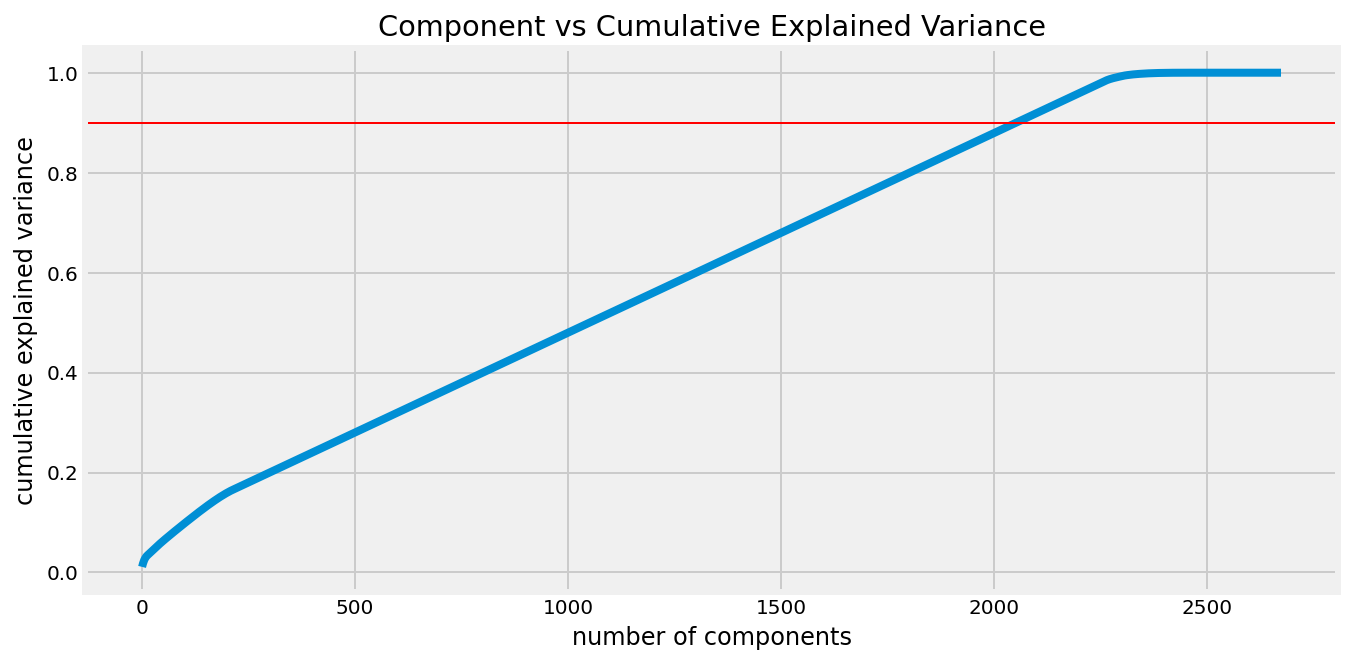

In [93]:
plt.figure(figsize=(10,5))
plt.title("Component vs Cumulative Explained Variance")
graph = sns.lineplot(data=np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
graph.axhline(y=0.9, lw=1, color='r');

We have superimposed a red horizontal line marking the point where the cumulative explained variance hits 90%. We see that about 2,000 principle components are sufficient to explain about 90% of the variance. To help accelerate model fitting further, we reduce the number of features to the first 2,000 principle components.

In [98]:
# Reduce the number of principle components (i.e features) to 2,000
X_train = X_train.iloc[:,:2000]
X_val = X_val.iloc[:,:2000]
X_test = X_test.iloc[:,:2000]

In [102]:
X_train.shape, X_val.shape, X_test.shape

((2675, 2000), (831, 2000), (986, 2000))

## Randomised search for optimal classifier parameters

To manage the total time and resources used to tune the classifier parameters, we use the RandomizedSearchCV to randomly select parameters from the specified ranges of parameters to give the best 5-fold cross-validated accuracy score on the training dataset, with a maximum of 10 iterations. We specify the range of parameters for each classifer based on experience and past results of running the RandomizedSearchCV.

We select the best classifier as the one with the highest balanced (weighted) accuracy score on the **validation dataset**.

In [103]:
def model_func(layer_one_neurons=1000, layer_one_dropout=0.2,
               layer_two_neurons=500, layer_two_dropout=0.2, opt_learning_rate=0.001):

    model = Sequential()

    model.add(Dense(layer_one_neurons, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(layer_one_dropout))

    model.add(Dense(layer_two_neurons, activation='relu'))
    model.add(Dropout(layer_two_dropout))

    model.add(Dense(9,activation='softmax'))

    Ad = optimizers.Adam(learning_rate=opt_learning_rate,
                         beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer=Ad,
                  metrics=['accuracy'], weighted_metrics=['accuracy'])
    return model

In [104]:
# We have selected a range of candidate classifiers
estimators = {
    'gnb': GaussianNB(), # Gaussian Naive Bayes Classifier
    'nn': KerasClassifier(build_fn=model_func, epochs=10), # Forward Neural Network Classifier
    'svc': SVC(random_state=42), # Support Vector Classifier
    'lr': LogisticRegression(random_state=42), # Logistic Regression Classifier
    'etree': ExtraTreesClassifier(random_state=42), # Extra Trees Classifier
    'ada': AdaBoostClassifier(random_state=42), # ADABoost Classifier
    'knn': KNeighborsClassifier(), # K-nearest Neighbours Classifier
    'rf': RandomForestClassifier(random_state=42), # Random Forest Classifier
    'dtree': DecisionTreeClassifier(random_state=42) # Decision Tree Classifier
}.items()

In [105]:
params = {
    'gnb': {
        'gnb__var_smoothing': np.logspace(-9, -1, num=20)
    },
    'nn': {
        'nn__layer_one_neurons': np.linspace(500, 2500, num=10, dtype='int').tolist(),
        'nn__layer_one_dropout': np.linspace(0.1, 0.5, num=5).tolist(),
        'nn__layer_two_neurons' : np.linspace(200, 1000, num=10, dtype='int').tolist(),
        'nn__layer_two_dropout': np.linspace(0.1, 0.5, num=5).tolist(),
        'nn__opt_learning_rate' : np.logspace(-3, -1, num=5).tolist()
    },
    'svc': {
        'svc__C': np.logspace(-3, 3, num=10),
        'svc__gamma': ['scale', 'auto'],
        'svc__kernel': ['linear','poly', 'rbf', 'sigmoid'],
        'svc__class_weight': ['balanced'] # 'balanced' will help to deal with our imbalanced classes
    },
    'lr': {
        # 'liblinear' solver has been excluded as a potential solver as it cannot learn a true multinomial
        # (multiclass) model; instead, the optimization problem is decomposed in a “one-vs-rest”
        # fashion so separate binary classifiers are trained for all classes.
        'lr__penalty': ['l1', 'l2', 'elasticnet'],
        'lr__C': np.logspace(-3, 3, num=10),
        'lr__class_weight': ['balanced'], # 'balanced' will help to deal with our imbalanced classes
        'lr__solver': ['newton-cg', 'lbfgs', 'sag','saga'], 
        'lr__multi_class': ['multinomial'],
        'lr__l1_ratio': np.linspace(0, 1, num=9)
    },
    'etree': {
        'etree__n_estimators': np.linspace(100, 200, num=10, dtype='int'),
        'etree__criterion': ['gini', 'entropy'],
        'etree__min_samples_split': np.linspace(2, 10, num=5, dtype='int'),
        'etree__min_samples_leaf': np.linspace(1, 10, num=5, dtype='int'),
        'etree__max_features': ['auto', 'sqrt', 'log2', None],
        'etree__class_weight': ['balanced'] # 'balanced' will help to deal with our imbalanced classes
    },
    'ada': {
        'ada__n_estimators': np.linspace(50, 200, num=10, dtype='int'),
        'ada__learning_rate': np.linspace(1, 5, num=9),
        'ada__algorithm': ['SAMME', 'SAMME.R']
    },
    'knn': {
        'knn__n_neighbors': np.linspace(5, 20, num=10, dtype='int'),
        'knn__weights': ['uniform', 'distance'],
        'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'knn__leaf_size': np.linspace(30, 50, num=10, dtype='int'),
        'knn__p': [1, 2],
        'knn__metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'rf': {
        'rf__n_estimators': np.linspace(100, 200, num=10, dtype='int'),
        'rf__criterion': ['gini', 'entropy'],
        'rf__min_samples_split': np.linspace(2, 10, num=5, dtype='int'),
        'rf__min_samples_leaf': np.linspace(1, 10, num=5, dtype='int'),
        'rf__max_features': ['auto', 'sqrt', 'log2', None],
        'rf__class_weight': ['balanced'] # 'balanced' will help to deal with our imbalanced classes
    },
    'dtree': {
        'dtree__criterion': ['gini', 'entropy'],
        'dtree__splitter': ['best', 'random'],
        'dtree__min_samples_split': np.linspace(2, 10, num=5, dtype='int'),
        'dtree__min_samples_leaf': np.linspace(1, 10, num=5, dtype='int'),
        'dtree__max_features': ['auto', 'sqrt', 'log2', None],
        'dtree__class_weight': ['balanced'] # 'balanced' will help to deal with our imbalanced classes
    }
}

We now use RandomizedSearchCV to select the optimal parameters for each classifier that produces the best 5-fold cross-validation balanced accuracy score based on the training dataset.

In [101]:
%%time
# initialise empty lists to store information later
models = []
parameters = []
best_score = []
train_bal_f1_score = []
val_bal_f1_score = []
train_bal_accuracy = []
val_bal_accuracy = []

for k,v in estimators:
    start = time.time()
    pipe = Pipeline([(k,v)])
    param = params[k]
    randomsearch = RandomizedSearchCV(
        n_iter = 10, # we set a max. of 10 iterations
        estimator = pipe,
        random_state = 42,
        param_distributions = param,
        verbose = 1,
        cv = 5, # 5-fold cross-validation
        n_jobs=None,
        return_train_score= True,
        scoring = 'balanced_accuracy' # cater for class imbalance
    )

    now = datetime.datetime.now()
    print ("Model: ", k)
    print ("Started fitting at: {}".format(now.strftime("%Y-%m-%d %H:%M:%S")))
    
    randomsearch.fit(X_train, y_train)
    
    model = randomsearch.best_estimator_
    cv_score = randomsearch.cv_results_
    best_params = randomsearch.best_params_

    # predict y
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # print results
    print ("Fitting duration (h:m:s): {}".format(str(datetime.timedelta(seconds=time.time()-start))))
    print ("Best parameters:", best_params)
    print ("Best cross-validation balanced accuracy score:", randomsearch.best_score_)
    print ("Training set balanced F1 score:", f1_score(y_train, y_train_pred, average='weighted'))
    print ("Validation set balanced F1 score:", f1_score(y_val, y_val_pred, average='weighted'))
    print ("Training set balanced accuracy:", balanced_accuracy_score(y_train,y_train_pred))
    print ("Validation set balanced accuracy:", balanced_accuracy_score(y_val,y_val_pred))
    print ("")
    
    # append info to list
    models.append(k)
    best_score.append(randomsearch.best_score_)
    parameters.append(best_params)
    train_bal_f1_score.append(f1_score(y_train,y_train_pred, average='weighted'))
    val_bal_f1_score.append(f1_score(y_val,y_val_pred, average='weighted'))
    train_bal_accuracy.append(balanced_accuracy_score(y_train,y_train_pred))
    val_bal_accuracy.append(balanced_accuracy_score(y_val,y_val_pred))

Model:  gnb
Started fitting at: 2020-04-10 18:30:42
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   52.7s finished


Fitting duration (h:m:s): 0:00:54.366432
Best parameters: {'gnb__var_smoothing': 1e-09}
Best cross-validation balanced accuracy score: 0.29637849807217603
Training set balanced F1 score: 0.36792417517817727
Validation set balanced F1 score: 0.0722631436560833
Training set balanced accuracy: 0.4275279278035152
Validation set balanced accuracy: 0.13261432793708872

Model:  nn
Started fitting at: 2020-04-10 18:31:36
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
 - 7s - loss: 1.8877 - accuracy: 0.3844 - accuracy_1: 0.3844
Epoch 2/10
 - 6s - loss: 0.0904 - accuracy: 0.9734 - accuracy_1: 0.9734
Epoch 3/10
 - 7s - loss: 0.0365 - accuracy: 0.9911 - accuracy_1: 0.9911
Epoch 4/10
 - 7s - loss: 0.0284 - accuracy: 0.9953 - accuracy_1: 0.9953
Epoch 5/10
 - 7s - loss: 0.0211 - accuracy: 0.9958 - accuracy_1: 0.9958
Epoch 6/10
 - 7s - loss: 0.0119 - accuracy: 0.9972 - accuracy_1: 0.9972
Epoch 7/10
 - 7s - loss: 0.0067 - accuracy: 0.9981 - accuracy_1: 0.9981
Epoch 8/10
 - 7s - loss: 0.0071 - accuracy: 0.9981 - accuracy_1: 0.9981
Epoch 9/10
 - 7s - loss: 0.0050 - accuracy: 0.9991 - accuracy_1: 0.9991
Epoch 10/10
 - 7s - loss: 0.0021 - accuracy: 0.9991 - accuracy_1: 0.9991
Epoch 1/10
 - 7s - loss: 1.9766 - accuracy: 0.3564 - accuracy_1: 0.3564
Epoch 2/10
 - 7s - loss: 0.1231 - accuracy: 0.9682 - accuracy_1: 0.9682
Epoch 3/10
 - 8s - loss: 0.0404 - accuracy: 0.9888 - accuracy_1: 0.9888
Epoch 4/10
 - 8s - loss: 0.0298 - accuracy: 0.9944 - accuracy_1

Epoch 5/10
 - 2s - loss: 0.0214 - accuracy: 0.9967 - accuracy_1: 0.9967
Epoch 6/10
 - 2s - loss: 0.0146 - accuracy: 0.9972 - accuracy_1: 0.9972
Epoch 7/10
 - 3s - loss: 0.0153 - accuracy: 0.9953 - accuracy_1: 0.9953
Epoch 8/10
 - 2s - loss: 0.0132 - accuracy: 0.9967 - accuracy_1: 0.9967
Epoch 9/10
 - 2s - loss: 0.0196 - accuracy: 0.9967 - accuracy_1: 0.9967
Epoch 10/10
 - 2s - loss: 0.0079 - accuracy: 0.9972 - accuracy_1: 0.9972
Epoch 1/10
 - 2s - loss: 2.1393 - accuracy: 0.2918 - accuracy_1: 0.2918
Epoch 2/10
 - 2s - loss: 0.3212 - accuracy: 0.9272 - accuracy_1: 0.9272
Epoch 3/10
 - 2s - loss: 0.0745 - accuracy: 0.9799 - accuracy_1: 0.9799
Epoch 4/10
 - 2s - loss: 0.0437 - accuracy: 0.9893 - accuracy_1: 0.9893
Epoch 5/10
 - 2s - loss: 0.0362 - accuracy: 0.9916 - accuracy_1: 0.9916
Epoch 6/10
 - 2s - loss: 0.0259 - accuracy: 0.9944 - accuracy_1: 0.9944
Epoch 7/10
 - 2s - loss: 0.0161 - accuracy: 0.9967 - accuracy_1: 0.9967
Epoch 8/10
 - 2s - loss: 0.0251 - accuracy: 0.9944 - accuracy_1

Epoch 9/10
 - 5s - loss: 2.1744 - accuracy: 0.2549 - accuracy_1: 0.2549
Epoch 10/10
 - 5s - loss: 2.0052 - accuracy: 0.2549 - accuracy_1: 0.2549
Epoch 1/10
 - 5s - loss: 110.8771 - accuracy: 0.2465 - accuracy_1: 0.2465
Epoch 2/10
 - 5s - loss: 98.6176 - accuracy: 0.2712 - accuracy_1: 0.2712
Epoch 3/10
 - 5s - loss: 37.8193 - accuracy: 0.2652 - accuracy_1: 0.2652
Epoch 4/10
 - 5s - loss: 199.5681 - accuracy: 0.2656 - accuracy_1: 0.2656
Epoch 5/10
 - 5s - loss: 19.7299 - accuracy: 0.2647 - accuracy_1: 0.2647
Epoch 6/10
 - 5s - loss: 2.1970 - accuracy: 0.2675 - accuracy_1: 0.2675
Epoch 7/10
 - 5s - loss: 14.5393 - accuracy: 0.2652 - accuracy_1: 0.2652
Epoch 8/10
 - 5s - loss: 8.1367 - accuracy: 0.2610 - accuracy_1: 0.2610
Epoch 9/10
 - 5s - loss: 6.7753 - accuracy: 0.2591 - accuracy_1: 0.2591
Epoch 10/10
 - 5s - loss: 9.6677 - accuracy: 0.2656 - accuracy_1: 0.2656
Epoch 1/10
 - 5s - loss: 110.4038 - accuracy: 0.2661 - accuracy_1: 0.2661
Epoch 2/10
 - 6s - loss: 43.4043 - accuracy: 0.2834 

Epoch 2/10
 - 3s - loss: 75.2115 - accuracy: 0.2834 - accuracy_1: 0.2834
Epoch 3/10
 - 3s - loss: 35.3635 - accuracy: 0.2838 - accuracy_1: 0.2838
Epoch 4/10
 - 3s - loss: 49.9555 - accuracy: 0.2843 - accuracy_1: 0.2843
Epoch 5/10
 - 3s - loss: 22.2242 - accuracy: 0.2843 - accuracy_1: 0.2843
Epoch 6/10
 - 3s - loss: 6.2115 - accuracy: 0.2852 - accuracy_1: 0.2852
Epoch 7/10
 - 3s - loss: 2.6723 - accuracy: 0.2857 - accuracy_1: 0.2857
Epoch 8/10
 - 3s - loss: 2.1007 - accuracy: 0.2801 - accuracy_1: 0.2801
Epoch 9/10
 - 3s - loss: 1.8444 - accuracy: 0.2768 - accuracy_1: 0.2768
Epoch 10/10
 - 3s - loss: 1.9335 - accuracy: 0.2838 - accuracy_1: 0.2838
Epoch 1/10
 - 4s - loss: 2.0210 - accuracy: 0.3204 - accuracy_1: 0.3204
Epoch 2/10
 - 4s - loss: 0.1670 - accuracy: 0.9664 - accuracy_1: 0.9664
Epoch 3/10
 - 4s - loss: 0.0391 - accuracy: 0.9925 - accuracy_1: 0.9925
Epoch 4/10
 - 4s - loss: 0.0300 - accuracy: 0.9935 - accuracy_1: 0.9935
Epoch 5/10
 - 4s - loss: 0.0307 - accuracy: 0.9939 - accura

Epoch 6/10
 - 6s - loss: 0.1046 - accuracy: 0.9832 - accuracy_1: 0.9832
Epoch 7/10
 - 6s - loss: 0.2026 - accuracy: 0.9790 - accuracy_1: 0.9790
Epoch 8/10
 - 5s - loss: 0.2930 - accuracy: 0.9654 - accuracy_1: 0.9654
Epoch 9/10
 - 5s - loss: 0.2526 - accuracy: 0.9696 - accuracy_1: 0.9696
Epoch 10/10
 - 6s - loss: 0.1572 - accuracy: 0.9738 - accuracy_1: 0.9738
Epoch 1/10
 - 6s - loss: 2.6525 - accuracy: 0.3512 - accuracy_1: 0.3512
Epoch 2/10
 - 6s - loss: 0.3174 - accuracy: 0.8935 - accuracy_1: 0.8935
Epoch 3/10
 - 6s - loss: 0.1222 - accuracy: 0.9687 - accuracy_1: 0.9687
Epoch 4/10
 - 6s - loss: 0.1030 - accuracy: 0.9794 - accuracy_1: 0.9794
Epoch 5/10
 - 6s - loss: 0.0538 - accuracy: 0.9869 - accuracy_1: 0.9869
Epoch 6/10
 - 6s - loss: 0.0440 - accuracy: 0.9911 - accuracy_1: 0.9911
Epoch 7/10
 - 6s - loss: 0.0562 - accuracy: 0.9893 - accuracy_1: 0.9893
Epoch 8/10
 - 6s - loss: 0.0858 - accuracy: 0.9851 - accuracy_1: 0.9851
Epoch 9/10
 - 6s - loss: 0.1663 - accuracy: 0.9785 - accuracy_1

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 33.9min finished


Epoch 1/10
 - 8s - loss: 1.9282 - accuracy: 0.3698 - accuracy_1: 0.3698
Epoch 2/10
 - 8s - loss: 0.1330 - accuracy: 0.9686 - accuracy_1: 0.9686
Epoch 3/10
 - 8s - loss: 0.0513 - accuracy: 0.9862 - accuracy_1: 0.9862
Epoch 4/10
 - 9s - loss: 0.0218 - accuracy: 0.9951 - accuracy_1: 0.9951
Epoch 5/10
 - 8s - loss: 0.0179 - accuracy: 0.9940 - accuracy_1: 0.9940
Epoch 6/10
 - 9s - loss: 0.0061 - accuracy: 0.9989 - accuracy_1: 0.9989
Epoch 7/10
 - 8s - loss: 0.0083 - accuracy: 0.9985 - accuracy_1: 0.9985
Epoch 8/10
 - 8s - loss: 0.0091 - accuracy: 0.9989 - accuracy_1: 0.9989
Epoch 9/10
 - 8s - loss: 0.0047 - accuracy: 0.9985 - accuracy_1: 0.9985
Epoch 10/10
 - 8s - loss: 0.0043 - accuracy: 0.9996 - accuracy_1: 0.9996
Fitting duration (h:m:s): 0:35:18.366510
Best parameters: {'nn__opt_learning_rate': 0.001, 'nn__layer_two_neurons': 555, 'nn__layer_two_dropout': 0.1, 'nn__layer_one_neurons': 2500, 'nn__layer_one_dropout': 0.30000000000000004}
Best cross-validation balanced accuracy score: 0.35

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 51.7min finished


Fitting duration (h:m:s): 0:53:09.450926
Best parameters: {'svc__kernel': 'linear', 'svc__gamma': 'scale', 'svc__class_weight': 'balanced', 'svc__C': 0.001}
Best cross-validation balanced accuracy score: 0.3959769602615789
Training set balanced F1 score: 0.9693848620914731
Validation set balanced F1 score: 0.45023306316225226
Training set balanced accuracy: 0.9385924902639415
Validation set balanced accuracy: 0.3651058347570982

Model:  lr
Started fitting at: 2020-04-10 20:00:04
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Deta

C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linea

Fitting duration (h:m:s): 0:07:43.331743
Best parameters: {'lr__solver': 'saga', 'lr__penalty': 'l2', 'lr__multi_class': 'multinomial', 'lr__l1_ratio': 0.0, 'lr__class_weight': 'balanced', 'lr__C': 215.44346900318823}
Best cross-validation balanced accuracy score: 0.43934311796591335
Training set balanced F1 score: 0.9785412234263128
Validation set balanced F1 score: 0.4501568478500982
Training set balanced accuracy: 0.9553763958366144
Validation set balanced accuracy: 0.40686658478415505

Model:  etree
Started fitting at: 2020-04-10 20:07:48
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  8.9min finished


Fitting duration (h:m:s): 0:10:35.824879
Best parameters: {'etree__n_estimators': 100, 'etree__min_samples_split': 4, 'etree__min_samples_leaf': 5, 'etree__max_features': None, 'etree__criterion': 'gini', 'etree__class_weight': 'balanced'}
Best cross-validation balanced accuracy score: 0.6320349183144263
Training set balanced F1 score: 0.9873220285093078
Validation set balanced F1 score: 0.0999676034292185
Training set balanced accuracy: 0.9910686813202392
Validation set balanced accuracy: 0.2294613827327374

Model:  ada
Started fitting at: 2020-04-10 20:18:23
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 81.2min finished


Fitting duration (h:m:s): 1:23:59.150717
Best parameters: {'ada__n_estimators': 200, 'ada__learning_rate': 1.5, 'ada__algorithm': 'SAMME'}
Best cross-validation balanced accuracy score: 0.3439759904046739
Training set balanced F1 score: 0.43047478180606563
Validation set balanced F1 score: 0.27567000493435645
Training set balanced accuracy: 0.41760520749407815
Validation set balanced accuracy: 0.23302586597827274

Model:  knn
Started fitting at: 2020-04-10 21:42:23
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 19.3min finished


Fitting duration (h:m:s): 0:19:52.024264
Best parameters: {'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 6, 'knn__metric': 'euclidean', 'knn__leaf_size': 38, 'knn__algorithm': 'ball_tree'}
Best cross-validation balanced accuracy score: 0.2837893239058483
Training set balanced F1 score: 1.0
Validation set balanced F1 score: 0.06255864323372329
Training set balanced accuracy: 1.0
Validation set balanced accuracy: 0.22739896249414226

Model:  rf
Started fitting at: 2020-04-10 22:02:15
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 42.5min finished


Fitting duration (h:m:s): 0:43:00.146749
Best parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 10, 'rf__max_features': 'sqrt', 'rf__criterion': 'entropy', 'rf__class_weight': 'balanced'}
Best cross-validation balanced accuracy score: 0.628521511906025
Training set balanced F1 score: 0.9188201461069293
Validation set balanced F1 score: 0.11153794710632604
Training set balanced accuracy: 0.935018083164347
Validation set balanced accuracy: 0.2360893543070764

Model:  dtree
Started fitting at: 2020-04-10 22:45:15
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.6s finished


Fitting duration (h:m:s): 0:00:09.058858
Best parameters: {'dtree__splitter': 'best', 'dtree__min_samples_split': 2, 'dtree__min_samples_leaf': 3, 'dtree__max_features': 'auto', 'dtree__criterion': 'entropy', 'dtree__class_weight': 'balanced'}
Best cross-validation balanced accuracy score: 0.4550123842781705
Training set balanced F1 score: 0.8611461375338213
Validation set balanced F1 score: 0.1956267279347246
Training set balanced accuracy: 0.9092512122529348
Validation set balanced accuracy: 0.23653887475142696

Wall time: 4h 14min 41s


## Selection of Alternative Model

In [102]:
# Produce a summary table of the tuned classifiers
summary = pd.DataFrame({
    'model': models,
    'parameters': parameters,
    'Best cross-validation balanced accuracy score': best_score,
    'Training set balanced F1 score': train_bal_f1_score,
    'Validation set balanced F1 score': val_bal_f1_score,
    'Training set balanced accuracy': train_bal_accuracy,
    'Validation set balanced accuracy': val_bal_accuracy
    })

pd.set_option('display.max_colwidth', None)
summary.sort_values('Validation set balanced accuracy', ascending=False).reset_index(drop=True)

,model,parameters,Best cross-validation balanced accuracy score,Training set balanced F1 score,Validation set balanced F1 score,Training set balanced accuracy,Validation set balanced accuracy
0,lr,"{'lr__solver': 'saga', 'lr__penalty': 'l2', 'lr__multi_class': 'multinomial', 'lr__l1_ratio': 0.0, 'lr__class_weight': 'balanced', 'lr__C': 215.44346900318823}",0.439343,0.978541,0.450157,0.955376,0.406867
1,nn,"{'nn__opt_learning_rate': 0.001, 'nn__layer_two_neurons': 555, 'nn__layer_two_dropout': 0.1, 'nn__layer_one_neurons': 2500, 'nn__layer_one_dropout': 0.30000000000000004}",0.351209,0.999252,0.414365,0.997585,0.397302
2,svc,"{'svc__kernel': 'linear', 'svc__gamma': 'scale', 'svc__class_weight': 'balanced', 'svc__C': 0.001}",0.395977,0.969385,0.450233,0.938592,0.365106
3,dtree,"{'dtree__splitter': 'best', 'dtree__min_samples_split': 2, 'dtree__min_samples_leaf': 3, 'dtree__max_features': 'auto', 'dtree__criterion': 'entropy', 'dtree__class_weight': 'balanced'}",0.455012,0.861146,0.195627,0.909251,0.236539
4,rf,"{'rf__n_estimators': 200, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 10, 'rf__max_features': 'sqrt', 'rf__criterion': 'entropy', 'rf__class_weight': 'balanced'}",0.628522,0.918820,0.111538,0.935018,0.236089
5,ada,"{'ada__n_estimators': 200, 'ada__learning_rate': 1.5, 'ada__algorithm': 'SAMME'}",0.343976,0.430475,0.275670,0.417605,0.233026
6,etree,"{'etree__n_estimators': 100, 'etree__min_samples_split': 4, 'etree__min_samples_leaf': 5, 'etree__max_features': None, 'etree__criterion': 'gini', 'etree__class_weight': 'balanced'}",0.632035,0.987322,0.099968,0.991069,0.229461
7,knn,"{'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 6, 'knn__metric': 'euclidean', 'knn__leaf_size': 38, 'knn__algorithm': 'ball_tree'}",0.283789,1.000000,0.062559,1.000000,0.227399
8,gnb,{'gnb__var_smoothing': 1e-09},0.296378,0.367924,0.072263,0.427528,0.132614


Based on the table above, we observe the following:
- The best performing model has a validation dataset balanced accuracy score of `0.406867` which is more than 10% better than our baseline accuracy score of `0.286962`.
- For all the models, the balanced F1 and accuracy scores for the validation dataset are lower that the respective scores on the training dataset -- this indicates that all our models tend to be overfitted.

<div class="alert alert-block alert-info">
In conclusion, our best alternative model is therefore the multinomial <b>Logistic Regression Classifier</b> with the parameters shown above, trained on <b>Word2Vec word embeddings</b> using the <b>Mean Embedding Vectorizer</b>.
</div>

## Further Exploration of Alternative Model

As before, to perform further exploration of our alternative model, we first instantiate the logistic regression classifier based on the best parameters found above, and then fit it on the validation dataset.

In [103]:
# We instantiate the best classifier based on the optimal parameters found above
alternative_clf = LogisticRegression(verbose=1, n_jobs=4, random_state=42, solver='saga', penalty='l2',
                                     multi_class='multinomial', l1_ratio=0,
                                     class_weight='balanced', C=215.44346900318823)

In [104]:
%%time
# Fit the best classifier on the validation dataset
alternative_clf.fit(X_val, y_val)

C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 12 seconds
Wall time: 12.1 s


C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   11.9s finished


LogisticRegression(C=215.44346900318823, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0,
                   max_iter=100, multi_class='multinomial', n_jobs=4,
                   penalty='l2', random_state=42, solver='saga', tol=0.0001,
                   verbose=1, warm_start=False)

### Logistic Regression Coefficients

As we did before for the baseline model, we now print out the top 5 principle components and their coefficients, for each of the 9 classes. A one-unit change in each principle component means that the prediction for the respective class is $e^{c}$ times as likely, where c is the coefficient value shown.

In [115]:
for cl in range(0,9):
    scores = pd.DataFrame(alternative_clf.coef_, columns=X_train.columns)
    print("\n---------------------------------------------------------------------------")
    print("Top 5 principle components and coefficient values for prediction of class {}".format(cl+1))
    print("---------------------------------------------------------------------------")
    print(np.exp(scores.loc[cl,np.exp(scores.loc[cl,:].sort_values(ascending=False)).head(5).index.tolist()]))


---------------------------------------------------------------------------
Top 5 principle components and coefficient values for prediction of class 1
---------------------------------------------------------------------------
PC7       1.335676
PC2278    1.210188
PC2272    1.132416
PC2449    1.109943
PC8       1.103854
Name: 0, dtype: float64

---------------------------------------------------------------------------
Top 5 principle components and coefficient values for prediction of class 2
---------------------------------------------------------------------------
PC4       1.138418
PC2       1.129772
PC2442    1.102479
PC2283    1.097884
PC63      1.093798
Name: 1, dtype: float64

---------------------------------------------------------------------------
Top 5 principle components and coefficient values for prediction of class 3
---------------------------------------------------------------------------
PC2401    1.178300
PC4       1.135836
PC186     1.119865
PC2398    1.113915

### ROC curves and metrics for Validation Dataset

In [105]:
# Generate predictions for the validation data based on our baseline model
y_val_pred = alternative_clf.predict(X_val)

In [106]:
# Binarize the output
y_train_binarized = label_binarize(y_train, classes=list(np.unique(y)))
y_val_pred_binarized = label_binarize(y_val_pred, classes=list(np.unique(y)))
n_classes = len(np.unique(y))

To come up with actual scores that can be used for ROC calculation, we use the OneVsRestClassifier coupled with a SVC (C-Support Vector) Classifier to fit the training dataset so that we can obtain the distances of each sample from the decision boundary for each class.

In [107]:
%%time
now = datetime.datetime.now()
print ("Started fitting at: {}".format(now.strftime("%Y-%m-%d %H:%M:%S")))
# We obtain the distances of each sample from the decision boundary for each class
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=42, verbose=1), n_jobs=2)
y_score = classifier.fit(X_train, y_train_binarized).decision_function(X_val)

Started fitting at: 2020-04-10 23:00:12
Wall time: 5min 8s


In [108]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # we compare our predicted labels for the validation dataset and the actual validation dataset labels
    fpr[i], tpr[i], _ = roc_curve(y_val_pred_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_pred_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

We plot ROC curves for all the 9 classes.

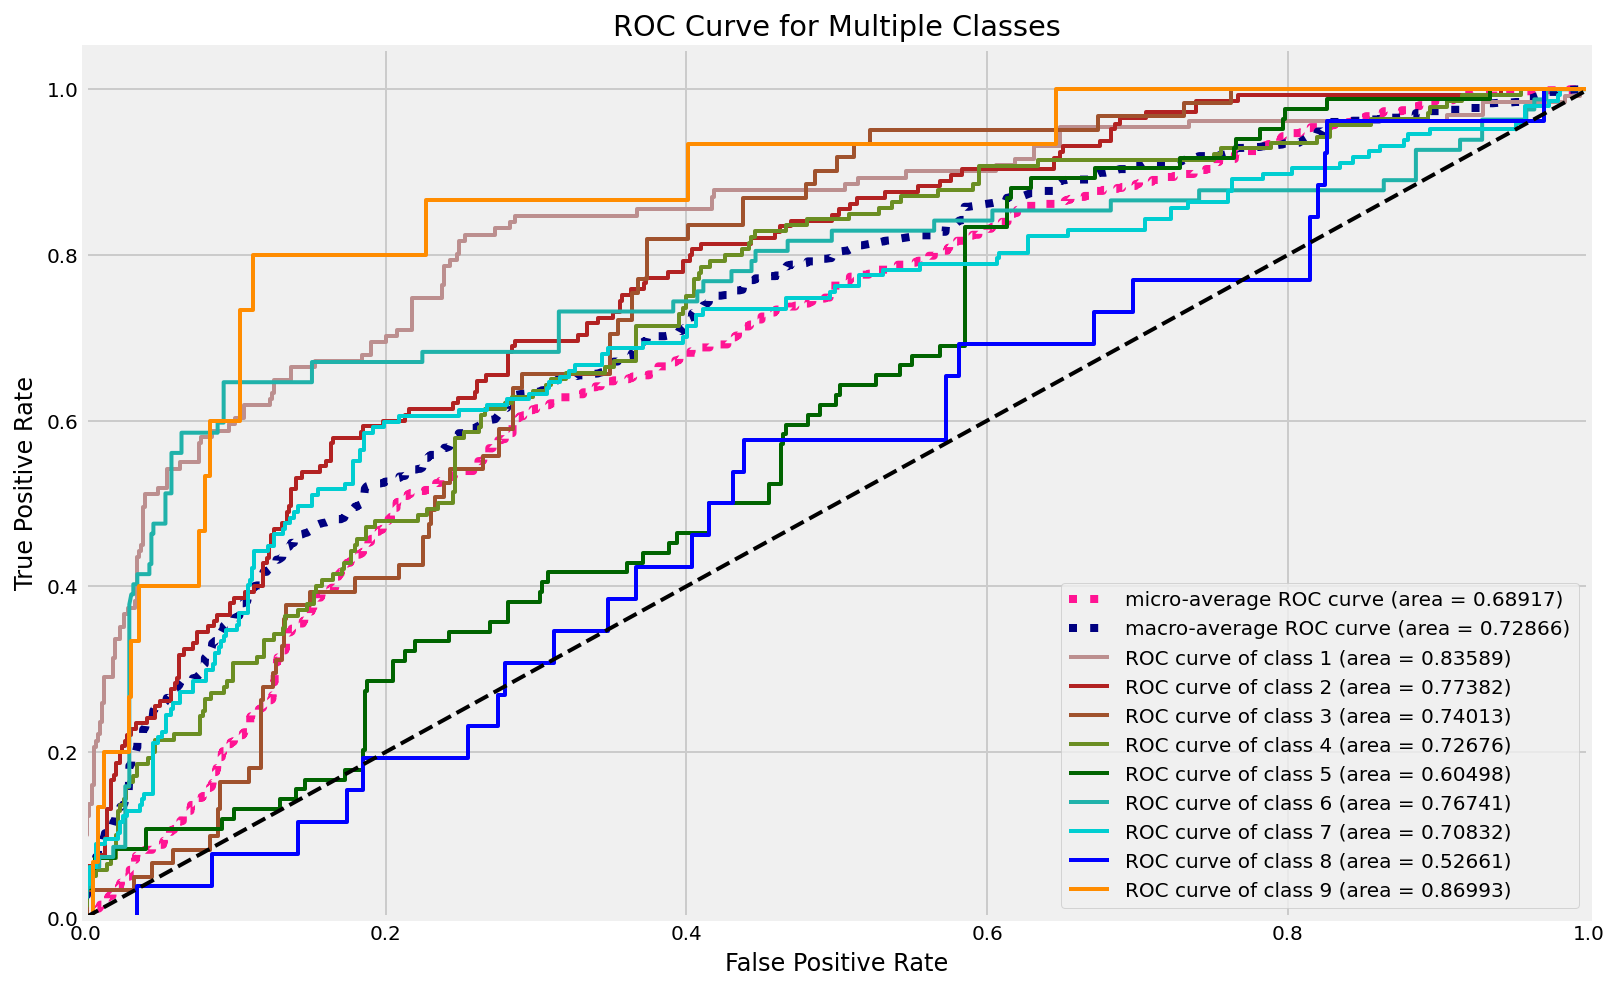

In [129]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

lw=2
colors = cycle(['rosybrown', 'firebrick', 'sienna', 'olivedrab', 'darkgreen',\
                'lightseagreen', 'darkturquoise', 'b', 'darkorange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiple Classes')
plt.legend(loc="lower right")
plt.show()

We note from the ROC curves and AUC scores ('area' metric) in the plot above that the micro-average AUC score is `0.68917` which is lower than the corresponding score of `0.87919` for the baseline model.

The individual AUCs for each of the nine classes are all lower than the corresponding scores in the baseline model for each class. The class 8 AUC (`0.52661`) is still the poorest amongst the nine classes.

### Confusion Matrix

We plot a confusion matrix can be used to evaluate the quality of the output of our classifier.

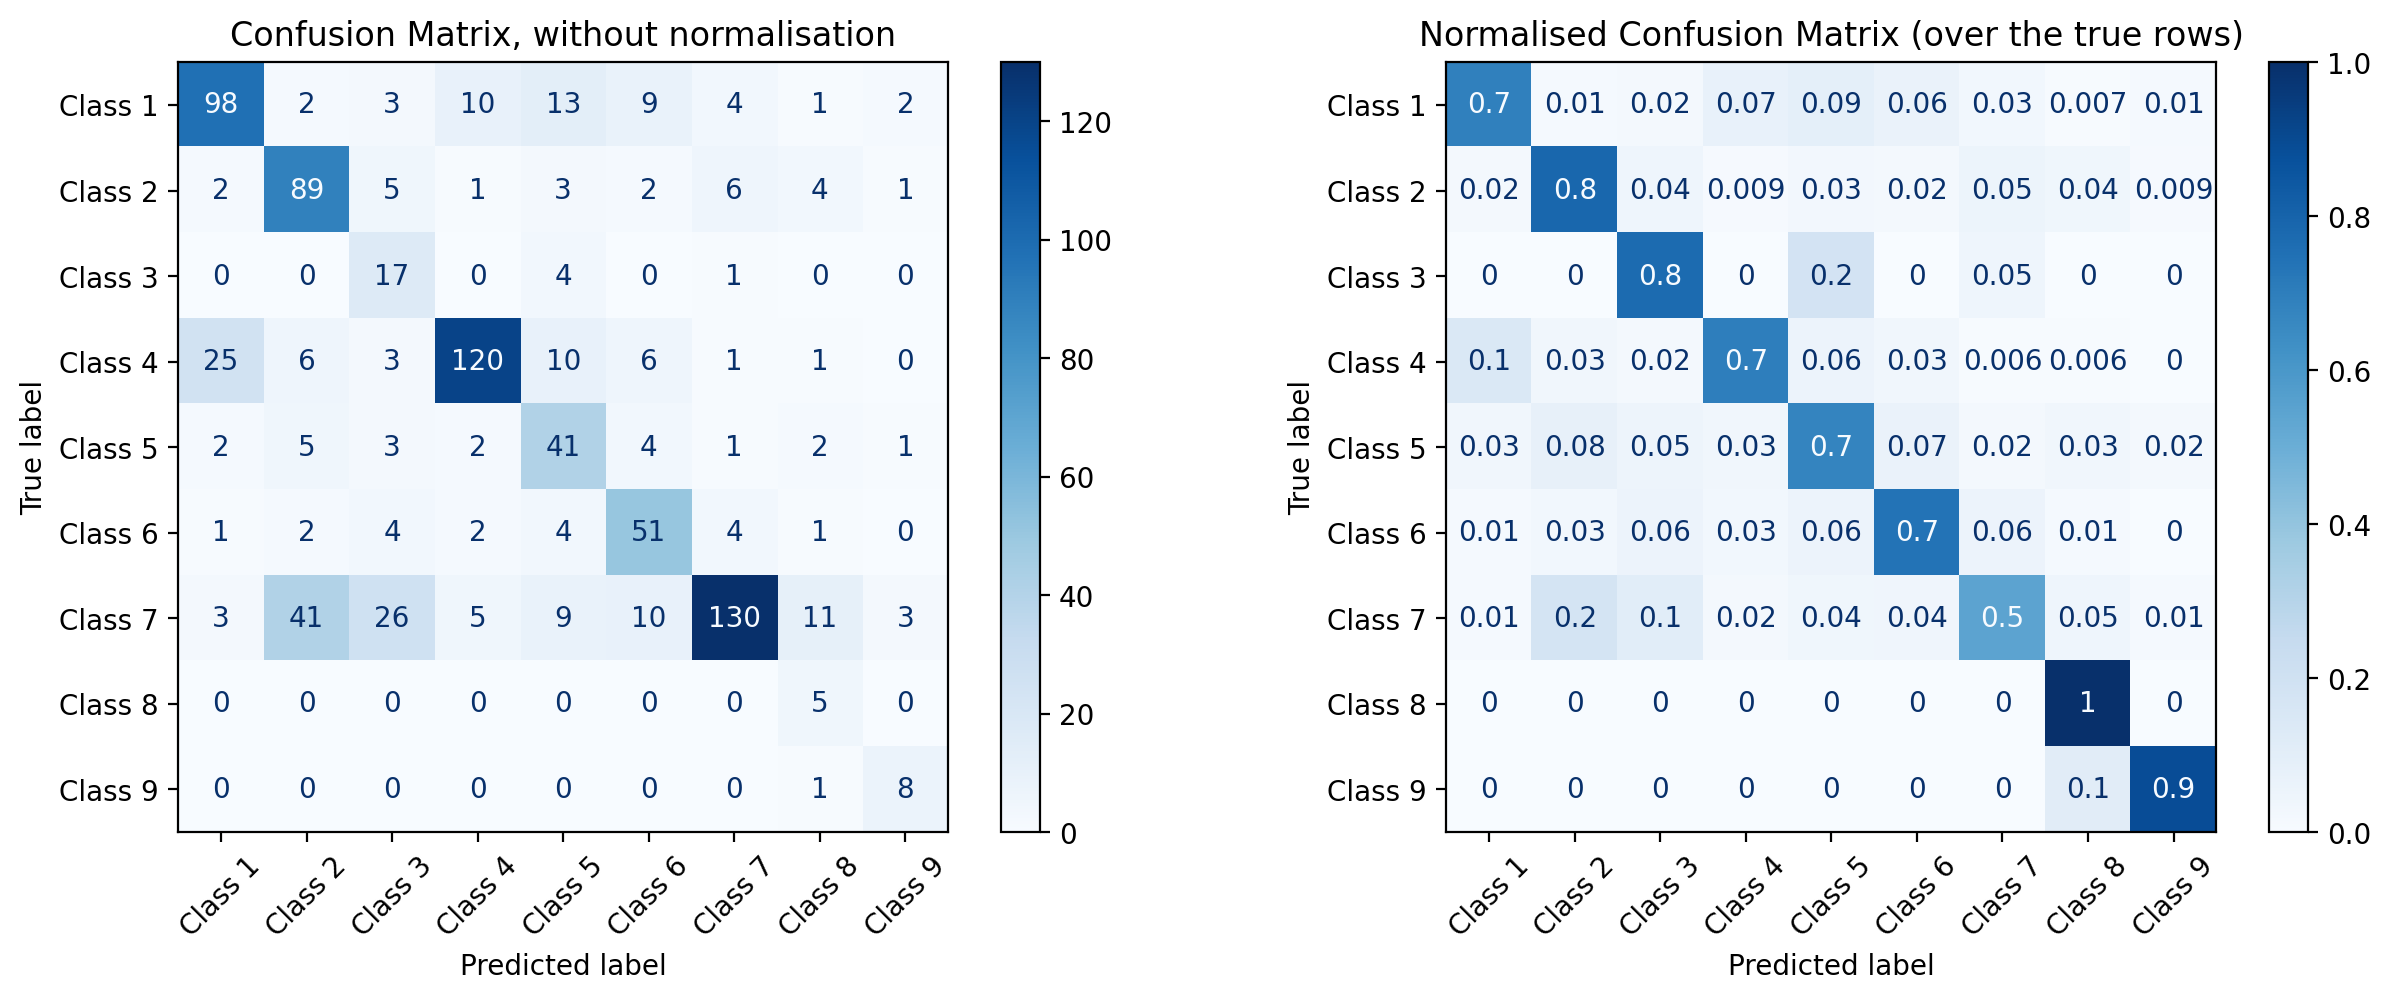

In [116]:
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
disp = plot_confusion_matrix(alternative_clf, X_val, y_val,
                             display_labels=['Class '+str(i+1) for i in range(0,9)],
                             cmap=plt.cm.Blues, values_format='.4g', xticks_rotation=45,
                             normalize=None, ax=ax1)
disp = plot_confusion_matrix(alternative_clf, X_val, y_val,
                             display_labels=['Class '+str(i+1) for i in range(0,9)],
                             cmap=plt.cm.Blues, values_format='.1g', xticks_rotation=45,
                             normalize='true', ax=ax2)
ax1.set_title("Confusion Matrix, without normalisation")
ax2.set_title("Normalised Confusion Matrix (over the true rows)")
plt.show();  

As shown above, the diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix thr better, indicating many correct predictions.

For the normalised confusion matrix, we note that the values in the diagonal are all equal or poorer (lower) than those found in the normalised confusion matrix for the baseline model.

### Comparison of Frequency Distributions

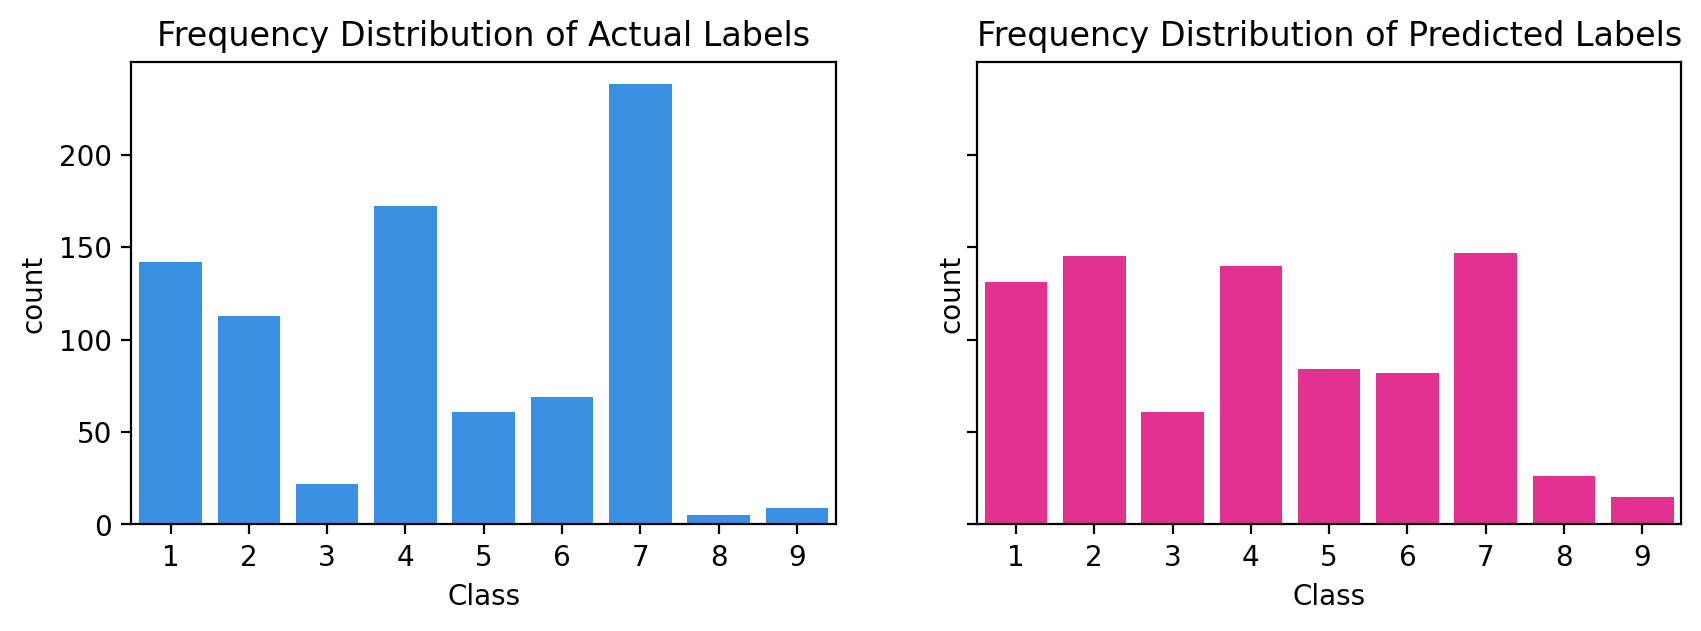

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
sns.countplot(y_val, color="dodgerblue", ax=axes[0])
sns.countplot(y_val_pred, color="deeppink", ax=axes[1]);
axes[0].set_title("Frequency Distribution of Actual Labels")
axes[1].set_title("Frequency Distribution of Predicted Labels")
axes[0].set_xlabel("Class")
axes[1].set_xlabel("Class");

A comparison of the two frequency distributions shows that:
- The relative frequencies of the classes have not been well preserved in the predictions, in particular for class 7 -- our alternative model predicts relatively fewer class 7 variations.
- The greater number of predictions for class 5 and 8 stand out, when we compare with the frequency of the actual labels.

## Selection of Final Model

The size of the training data has been reduced significantly from over 76,000 features (created using the standard TfidfVectorizer) to around 4,400, which is approx. 20 times smaller. This has led to faster training times for the alternative model.

Unfortunately, variance has increased as a result, and the alternative model is more overfitted compared to the baseline model, based on a comparison of the validation dataset balanced accuracy scores. The evidence of this can be seen in the ROC curves, confusion matrix and histogram plots above. The alternative model scores more poorly in terms of the balanced accuracy and F1 scores, as well as the micro-average AUC score, as shown below:

|Metric|Baseline Model<br>(Logistic Regression with<br>Tfidf word weights)|Alternative Model<br>(Logistic Regression using<br>mean Word2Vec embeddings)|
|:--|---|---|
|Balanced Accuracy Score|0.532911|0.406867|
|Balanced F1 Score|0.598815|0.450157|
|Micro-average AUC score|0.87919|0.68917|

We therefore choose the baseline model as our final model -- i.e. the multinomial <b>Logistic Regression Classifier</b> trained on <b>TfidfVectorizer</b> weighted word frequencies. It meets our success criteria of exceeding the baseline accuracy of `0.286962` by at least 10%. The full parameters of the Logistic Regression Classifier are shown below.

```
LogisticRegression(C=215.44346900318823, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=42, solver='saga', tol=0.0001,
                   verbose=1, warm_start=False)
```

## Data Export (for Kaggle Submission)

For completeness, we export the predictions from the alternative model for Kaggle submission in Notebook 5.

In [118]:
y_test_pred = alternative_clf.predict(X_test)

In [119]:
y_test_pred.shape

(986,)

In [120]:
# Restore the 'id' column since we need this for the Kaggle submission
test_pred = pd.concat([test['id'], pd.DataFrame(y_test_pred, columns=['class'])], axis=1)

In [121]:
# Verify that we have a mix of predictions for variation classes
test_pred['class'].value_counts()

2    227
1    176
4    169
7    164
6     85
5     61
3     58
8     32
9     14
Name: class, dtype: int64

In [122]:
test_pred.head()

,id,class
0,1,6
1,2,1
2,3,7
3,4,1
4,5,2


In [123]:
# We export the predictions
test_pred.to_csv("../assets/test_pred.csv", index=False)